Esketit
---

In [32]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

In [49]:
pre_path = 'data/'
suffix = '_w_lix_sentiment.csv'

subreddits = list(glob.glob('data/*'))
subreddits = list(set([sub.split('\\')[1].split('_')[0] for sub in subreddits]))
items_to_remove = ['combined', 'cleaned', 'word2vec.model', 'sentiment']
subreddits = [sub for sub in subreddits if sub not in items_to_remove]
print(subreddits)

n_subs =  len(subreddits)

['baking', 'Palestine', 'worldnews', 'Israel', 'politics']


In [50]:
dfs = {}
for sub in subreddits:
    dfs[sub] = pd.read_csv(pre_path + sub + suffix, index_col = 'comment_id')

attribute_cols = ['sentiment_score', 'log_lix_score','log_upvotes']

Spørgsmål:  
Hvorfor log-transformerer vi upvotes?  
Bør vi log-transformere lix?  
Hvorfor vælger vi standardisering frem for normalisering?  
Hvorfor vælger vi at evaluere på Silhuette Score i stedet for Davies Bouldin Score eller Calinski-Harabasz Score? Og for GMM hvorfor evaluerer vi ikke bare log-likelihood?  

First off, let's inspect the data transformations
---
Hypothesis: We want to log transform likes.
Then we want to either standardize or normalize all 3 parameters, so they are equally distant. Unless of course we want some parameter to have a higher weight?
For the standardize/normalize we should do the 3 scatterplots, 3 for normal and 3 for standard

### Log-transforming likes (Should be shown in report but not relevant in optimization)

In [84]:
# dt['log_upvotes'] = dt['upvotes'].apply(lambda x: np.log(x))

# fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))

# sns.histplot(ax = axs[0], data=dt, x="upvotes", log_scale = False)
# sns.histplot(ax = axs[1], data=dt, x="upvotes", log_scale = True)

# fig.suptitle(f'Upvotes vs. log-transformed upvotes in r/{sub_chosen}', fontsize=16)
# fig.tight_layout()
# plt.show()

Find the optimal model
---

In [101]:
# It goes something like this:
# attribute_cols = ['sentiment_score', 'log_lix_score','log_upvotes']

gmm_sil_s = {}
gmm_sil_n = {}
hierarchical_sil_s = {}
hierarchical_sil_n = {}
kmeans_sil_s = {}
kmeans_sil_n = {}

gmm_cal_s = {}
gmm_cal_n = {}
hierarchical_cal_s = {}
hierarchical_cal_n = {}
kmeans_cal_s = {}
kmeans_cal_n = {}

n_clusters_range = range(2, 20)

seed = 42


for sub, df in dfs.items():
    df = df[attribute_cols]

    gmm_sil_s[sub] = []
    gmm_sil_n[sub] = []
    gmm_cal_s[sub] = []
    gmm_cal_n[sub] = []

    hierarchical_sil_s[sub] = []
    hierarchical_sil_n[sub] = []
    hierarchical_cal_s[sub] = []
    hierarchical_cal_n[sub] = []

    kmeans_cal_s[sub] = []
    kmeans_cal_n[sub] = []
    kmeans_sil_s[sub] = []
    kmeans_sil_n[sub] = []

    points_s = StandardScaler().fit_transform(df)
    points_n = minmax_scale(df, axis = 0)

    for n_clusters in n_clusters_range:

        GMM_s = GaussianMixture(n_components=n_clusters, random_state = seed)
        GMM_n = GaussianMixture(n_components=n_clusters, random_state = seed)
        GMM_s.fit(points_s)
        GMM_n.fit(points_n)

        hierarchical_s = AgglomerativeClustering(n_clusters=n_clusters)
        hierarchical_n = AgglomerativeClustering(n_clusters=n_clusters)
        hierarchical_s.fit(points_s)
        hierarchical_n.fit(points_n)

        kmeans_s = KMeans(n_clusters=n_clusters, random_state = seed) 
        kmeans_n = KMeans(n_clusters=n_clusters, random_state = seed)
        kmeans_s.fit(points_s)
        kmeans_n.fit(points_n)


        hierarchical_sil_s[sub].append(silhouette_score(points_s, hierarchical_s.labels_))
        hierarchical_sil_n[sub].append(silhouette_score(points_n, hierarchical_n.labels_))
        hierarchical_cal_s[sub].append(calinski_harabasz_score(points_s, hierarchical_s.labels_))
        hierarchical_cal_n[sub].append(calinski_harabasz_score(points_n, hierarchical_n.labels_))

        kmeans_sil_s[sub].append(silhouette_score(points_s, kmeans_s.labels_))
        kmeans_sil_n[sub].append(silhouette_score(points_n, kmeans_n.labels_))
        kmeans_cal_s[sub].append(calinski_harabasz_score(points_s, kmeans_s.labels_))
        kmeans_cal_n[sub].append(calinski_harabasz_score(points_n, kmeans_n.labels_))

        gmm_sil_s[sub].append(silhouette_score(points_s, GMM_s.predict(points_s)))
        gmm_sil_n[sub].append(silhouette_score(points_n, GMM_n.predict(points_n)))
        gmm_cal_s[sub].append(calinski_harabasz_score(points_s, GMM_s.predict(points_s)))
        gmm_cal_n[sub].append(calinski_harabasz_score(points_n, GMM_n.predict(points_n)))


In [102]:
print(kmeans_sil_s['Israel'][0:5])
print(kmeans_sil_n['Israel'][0:5])

[np.float64(0.2600215602132991), np.float64(0.3015089090446598), np.float64(0.29449356318817393), np.float64(0.2754607316326752), np.float64(0.2558067214699618)]
[np.float64(0.3943922372619283), np.float64(0.33390490849427223), np.float64(0.3191367020689248), np.float64(0.30446266304714426), np.float64(0.29503648760370416)]


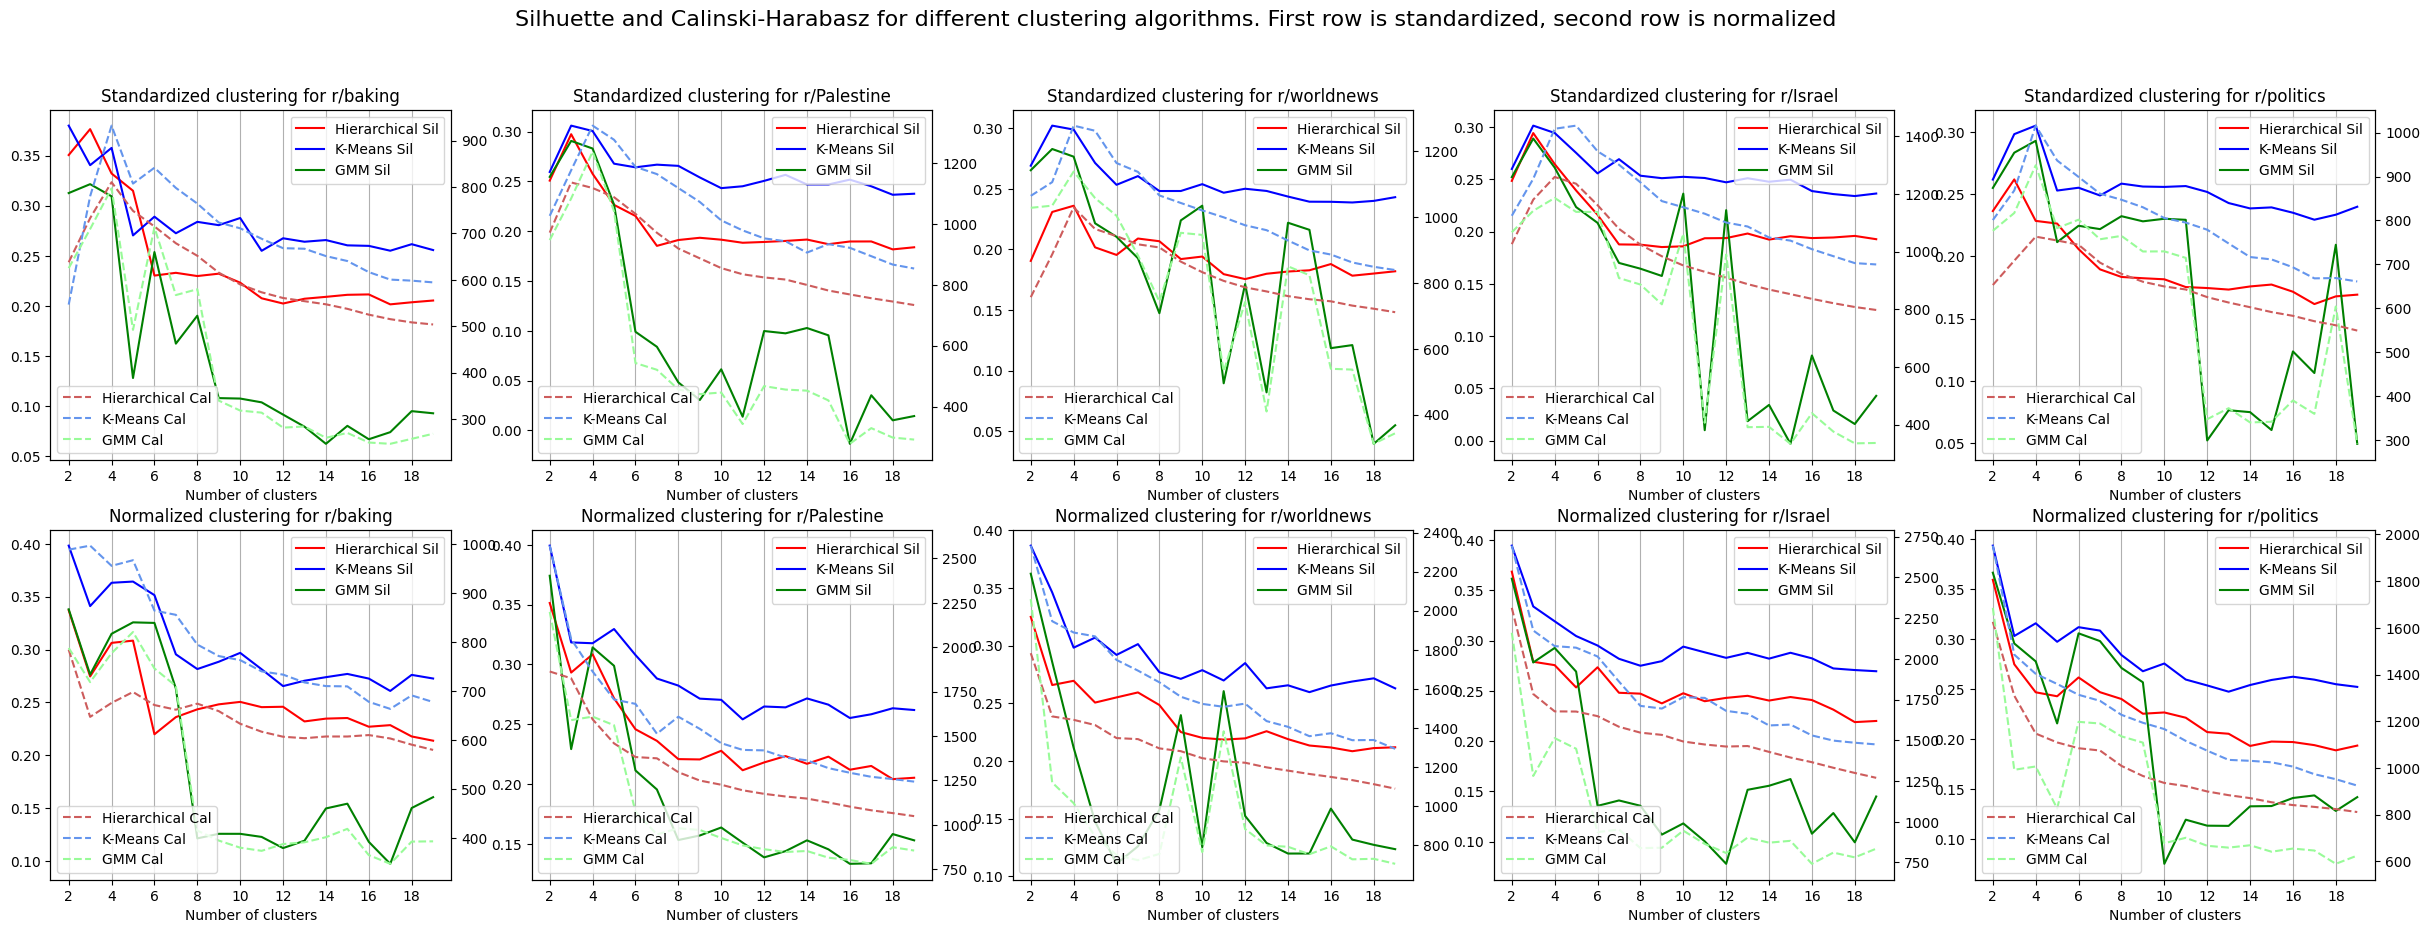

In [107]:
fig, axes = plt.subplots(nrows=2, ncols=n_subs, figsize=(30, 10))
x_list = n_clusters_range

fig.suptitle('Silhuette and Calinski-Harabasz for different clustering algorithms. First row is standardized, second row is normalized', fontsize=16)
for i, sub in enumerate(subreddits):
    axes[0, i].set_title(f'Standardized clustering for r/{sub}', fontsize=12)
    axes[0, i].plot(x_list, hierarchical_sil_s[sub], label='Hierarchical Sil', color='red') 
    axes[0, i].plot(x_list, kmeans_sil_s[sub], label='K-Means Sil', color='blue') 
    axes[0, i].plot(x_list, gmm_sil_s[sub], label='GMM Sil', color='green') 
    cal_ax = axes[0, i].twinx()
    cal_ax.plot(x_list, hierarchical_cal_s[sub], label='Hierarchical Cal', color='indianred', linestyle='--') 
    cal_ax.plot(x_list, kmeans_cal_s[sub], label='K-Means Cal', color='cornflowerblue', linestyle='--') 
    cal_ax.plot(x_list, gmm_cal_s[sub], label='GMM Cal', color='palegreen', linestyle='--') 
    cal_ax.legend(loc='lower left')
    axes[0, i].legend(loc='upper right')
    axes[0, i].set_xlabel('Number of clusters')
    axes[0, i].set_xticks(x_list[::2])
    axes[0, i].grid(True, axis='x')


for i, sub in enumerate(subreddits):
    axes[1, i].set_title(f'Normalized clustering for r/{sub}', fontsize=12)
    axes[1, i].plot(x_list, hierarchical_sil_n[sub], label='Hierarchical Sil', color='red') 
    axes[1, i].plot(x_list, kmeans_sil_n[sub], label='K-Means Sil', color='blue') 
    axes[1, i].plot(x_list, gmm_sil_n[sub], label='GMM Sil', color='green') 
    cal_ax = axes[1, i].twinx()
    cal_ax.plot(x_list, hierarchical_cal_n[sub], label='Hierarchical Cal', color='indianred', linestyle='--') 
    cal_ax.plot(x_list, kmeans_cal_n[sub], label='K-Means Cal', color='cornflowerblue', linestyle='--') 
    cal_ax.plot(x_list, gmm_cal_n[sub], label='GMM Cal', color='palegreen', linestyle='--') 
    cal_ax.legend(loc='lower left')
    axes[1, i].legend(loc='upper right')
    axes[1, i].set_xlabel('Number of clusters')
    axes[1, i].set_xticks(x_list[::2])
    axes[1, i].grid(True, axis='x')


plt.show()


Normalized data provides better clusters, though still weak. Silhuette score is not scaled by normalization / standardization, so this does not explain the better values for normalization.  

Spikes in silhuette score, supported by Calinski-Harabasz score, shows around 5 clusters for all of the subreddits.    

This has been tested for multiple seeds for kmeans and GMM. The different plots can be found by changed seed in the code which generates the results.  
K-means outperforms the other algorithms on all subreddits.   
All subreddits will be analyzed using kmeans with 5 clusters.  

DBSCAN does not even come close - see for yourself on below graph
---

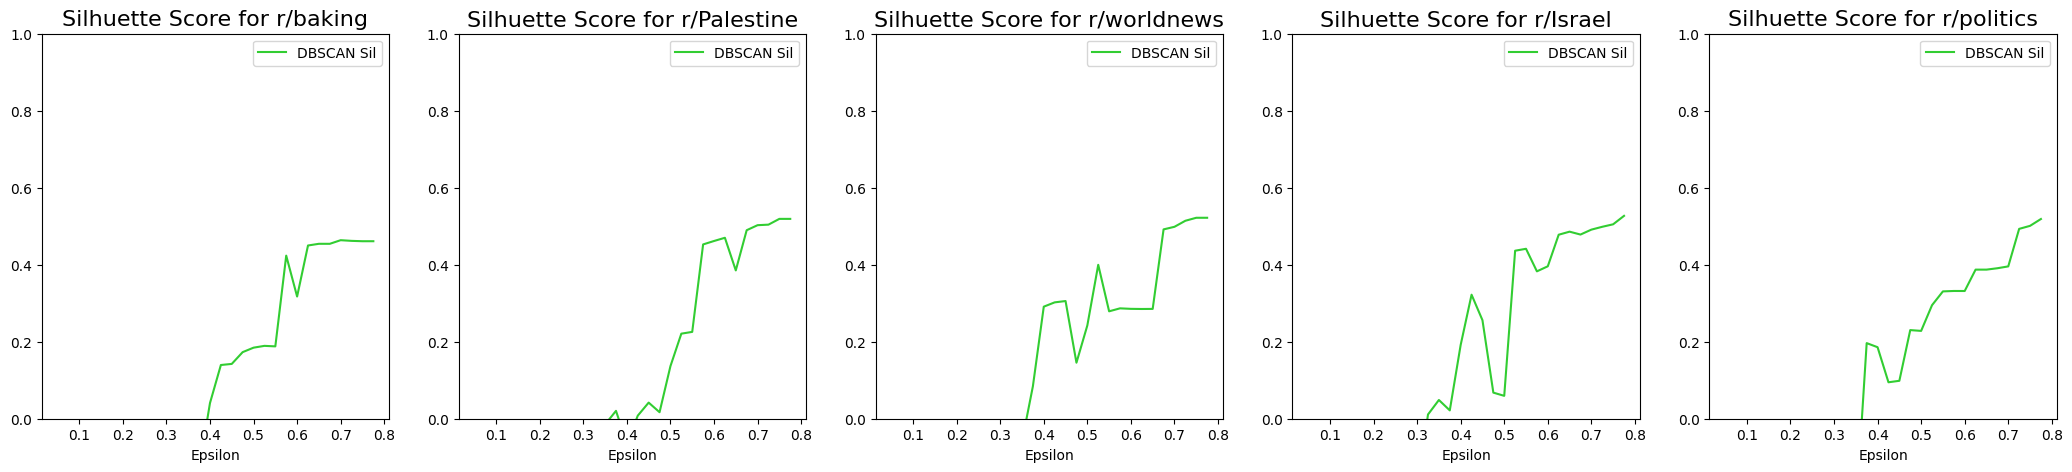

In [108]:
# Let's do the same shit but with DBSCAN
# attribute_cols = ['sentiment_score', 'lix_score','log_upvotes']

DBSCAN_sil_n = {}

epsilons = np.arange(0.05, 0.80, 0.025)


for sub, df in dfs.items():
    df = df[attribute_cols]
    DBSCAN_sil_n[sub] = []
    points = StandardScaler().fit_transform(df)
    for ep in epsilons:
        dbscan = DBSCAN(eps=ep) #eps is max distance between points for the same cluster
        dbscan.fit(points)
        
        #davies_bouldin_score not defined for single cluster
        if len(np.unique(dbscan.labels_)) == 1:
            DBSCAN_sil_n[sub].append(-1)
        else:
            DBSCAN_sil_n[sub].append(silhouette_score(points, dbscan.labels_))

fig, axes = plt.subplots(nrows = 1 ,ncols = n_subs, figsize=(26, 5))
x_list = epsilons

for i, sub in enumerate(subreddits):
    axes[i].set_title(f'Silhuette Score for r/{sub}', fontsize=16)
    axes[i].plot(x_list, DBSCAN_sil_n[sub], label = 'DBSCAN Sil', color = 'limegreen')
    axes[i].legend()
    axes[i].set_xlabel('Epsilon')
    axes[i].set_ylim(0, 1)

plt.show()

DBSCAN gets higher silhuette values, but that is because it just assigns everything in the subreddit to the same cluster.

Run the optimized models here
---

In [109]:
# optimal_clusters['others'] = {
#     'Israel' : 5,
#     'Palestine' : 4,
#     'politics' : 4,
#     'worldnews' : 4,
#     'baking': 4
# }

optimal_clusters = 5

optimal_epsilons = {
    'Israel' : 0.625,
    'Palestine' : 0.625,
    'politics' : 0.8,
    'worldnews' : 0.525,
    'baking': 0.575
}

for sub, df in dfs.items():
    df_cluster = df[attribute_cols].copy()
    
    # #Standardize the data
    df_cluster_scaled = StandardScaler().fit_transform(df_cluster)

    # #Apply clustering using tuned hyperparameters
    gmm_n_clusters = optimal_clusters
    n_clusters = optimal_clusters
    ep = optimal_epsilons[sub]

    GMM = GaussianMixture(n_components=gmm_n_clusters)
    GMM.fit(df_cluster_scaled)

    dbscan = DBSCAN(eps=ep) #eps is max distance between points for the same cluster
    dbscan.fit(df_cluster_scaled)

    kmeans = KMeans(n_clusters=n_clusters, random_state = 42)
    kmeans.fit(df_cluster_scaled)

    #Assign the cluster labels
    df['DBSCAN_cluster'] = dbscan.labels_
    df['GMM_cluster'] = GMM.predict(df_cluster_scaled)
    df['kmeans_cluster'] = kmeans.labels_


    # #### Export the new dataframes
    df.to_csv(f'data/{sub}_clustered.csv')


Load the data and analyze it ----> USE EVERYTHING AFTER THIS FOR CLUSTER_ANALYSIS
---

In [110]:
pre_path = 'data/'
suffix = '_clustered.csv'

subreddits = list(glob.glob('data/*'))
subreddits = list(set([sub.split('\\')[1].split('_')[0] for sub in subreddits]))
items_to_remove = ['combined', 'cleaned', 'word2vec.model', 'sentiment']
subreddits = [sub for sub in subreddits if sub not in items_to_remove]

n_subs =  len(subreddits)

dfs_clustered = {}
for sub in subreddits:
    dfs_clustered[sub] = pd.read_csv(pre_path + sub + suffix, index_col = 'comment_id')

attribute_cols = ['sentiment_score', 'log_lix_score','log_upvotes']

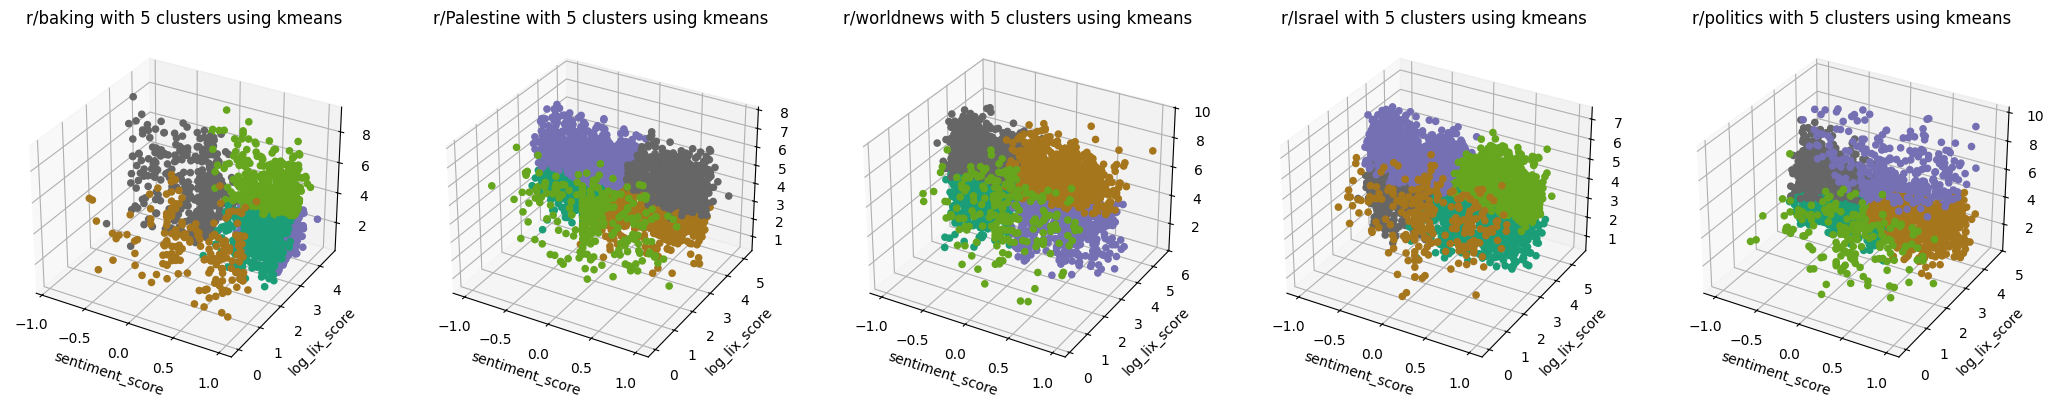

In [116]:
fig, axes = plt.subplots(nrows=1, ncols=n_subs, figsize=(26, 5), subplot_kw={'projection': '3d'})

method = 'kmeans' #DBSCAN, GMM, kmeans
cluster_type = f'{method}_cluster'

for i, (sub, df) in enumerate(dfs_clustered.items()):
    n_clusters = df[cluster_type].nunique()

    # Set color: grey for cluster -1, others will use a colormap
    colors = df[cluster_type].apply(lambda x: 'grey' if x == -1 else None)
    
    # Assign transparency: 50% for cluster -1, 100% (1.0) for others
    alphas = df[cluster_type].apply(lambda x: 0.1 if x == -1 else 1.0)

    # Handle valid colors for other clusters
    # Replace 'None' with colormap values for non -1 clusters
    cmap = plt.get_cmap('Dark2', n_clusters)
    cluster_colors = df[cluster_type].apply(lambda x: cmap(x) if x != -1 else 'grey')

    # Plot the 3D scatterplot
    scatter = axes[i].scatter(
        df[attribute_cols[0]], df[attribute_cols[1]], df[attribute_cols[2]],
        facecolors=cluster_colors, alpha=alphas
    )
    axes[i].set_title(f'r/{sub} with {n_clusters} clusters using {method}')
    axes[i].set_xlabel(attribute_cols[0])
    axes[i].set_ylabel(attribute_cols[1])

plt.show()


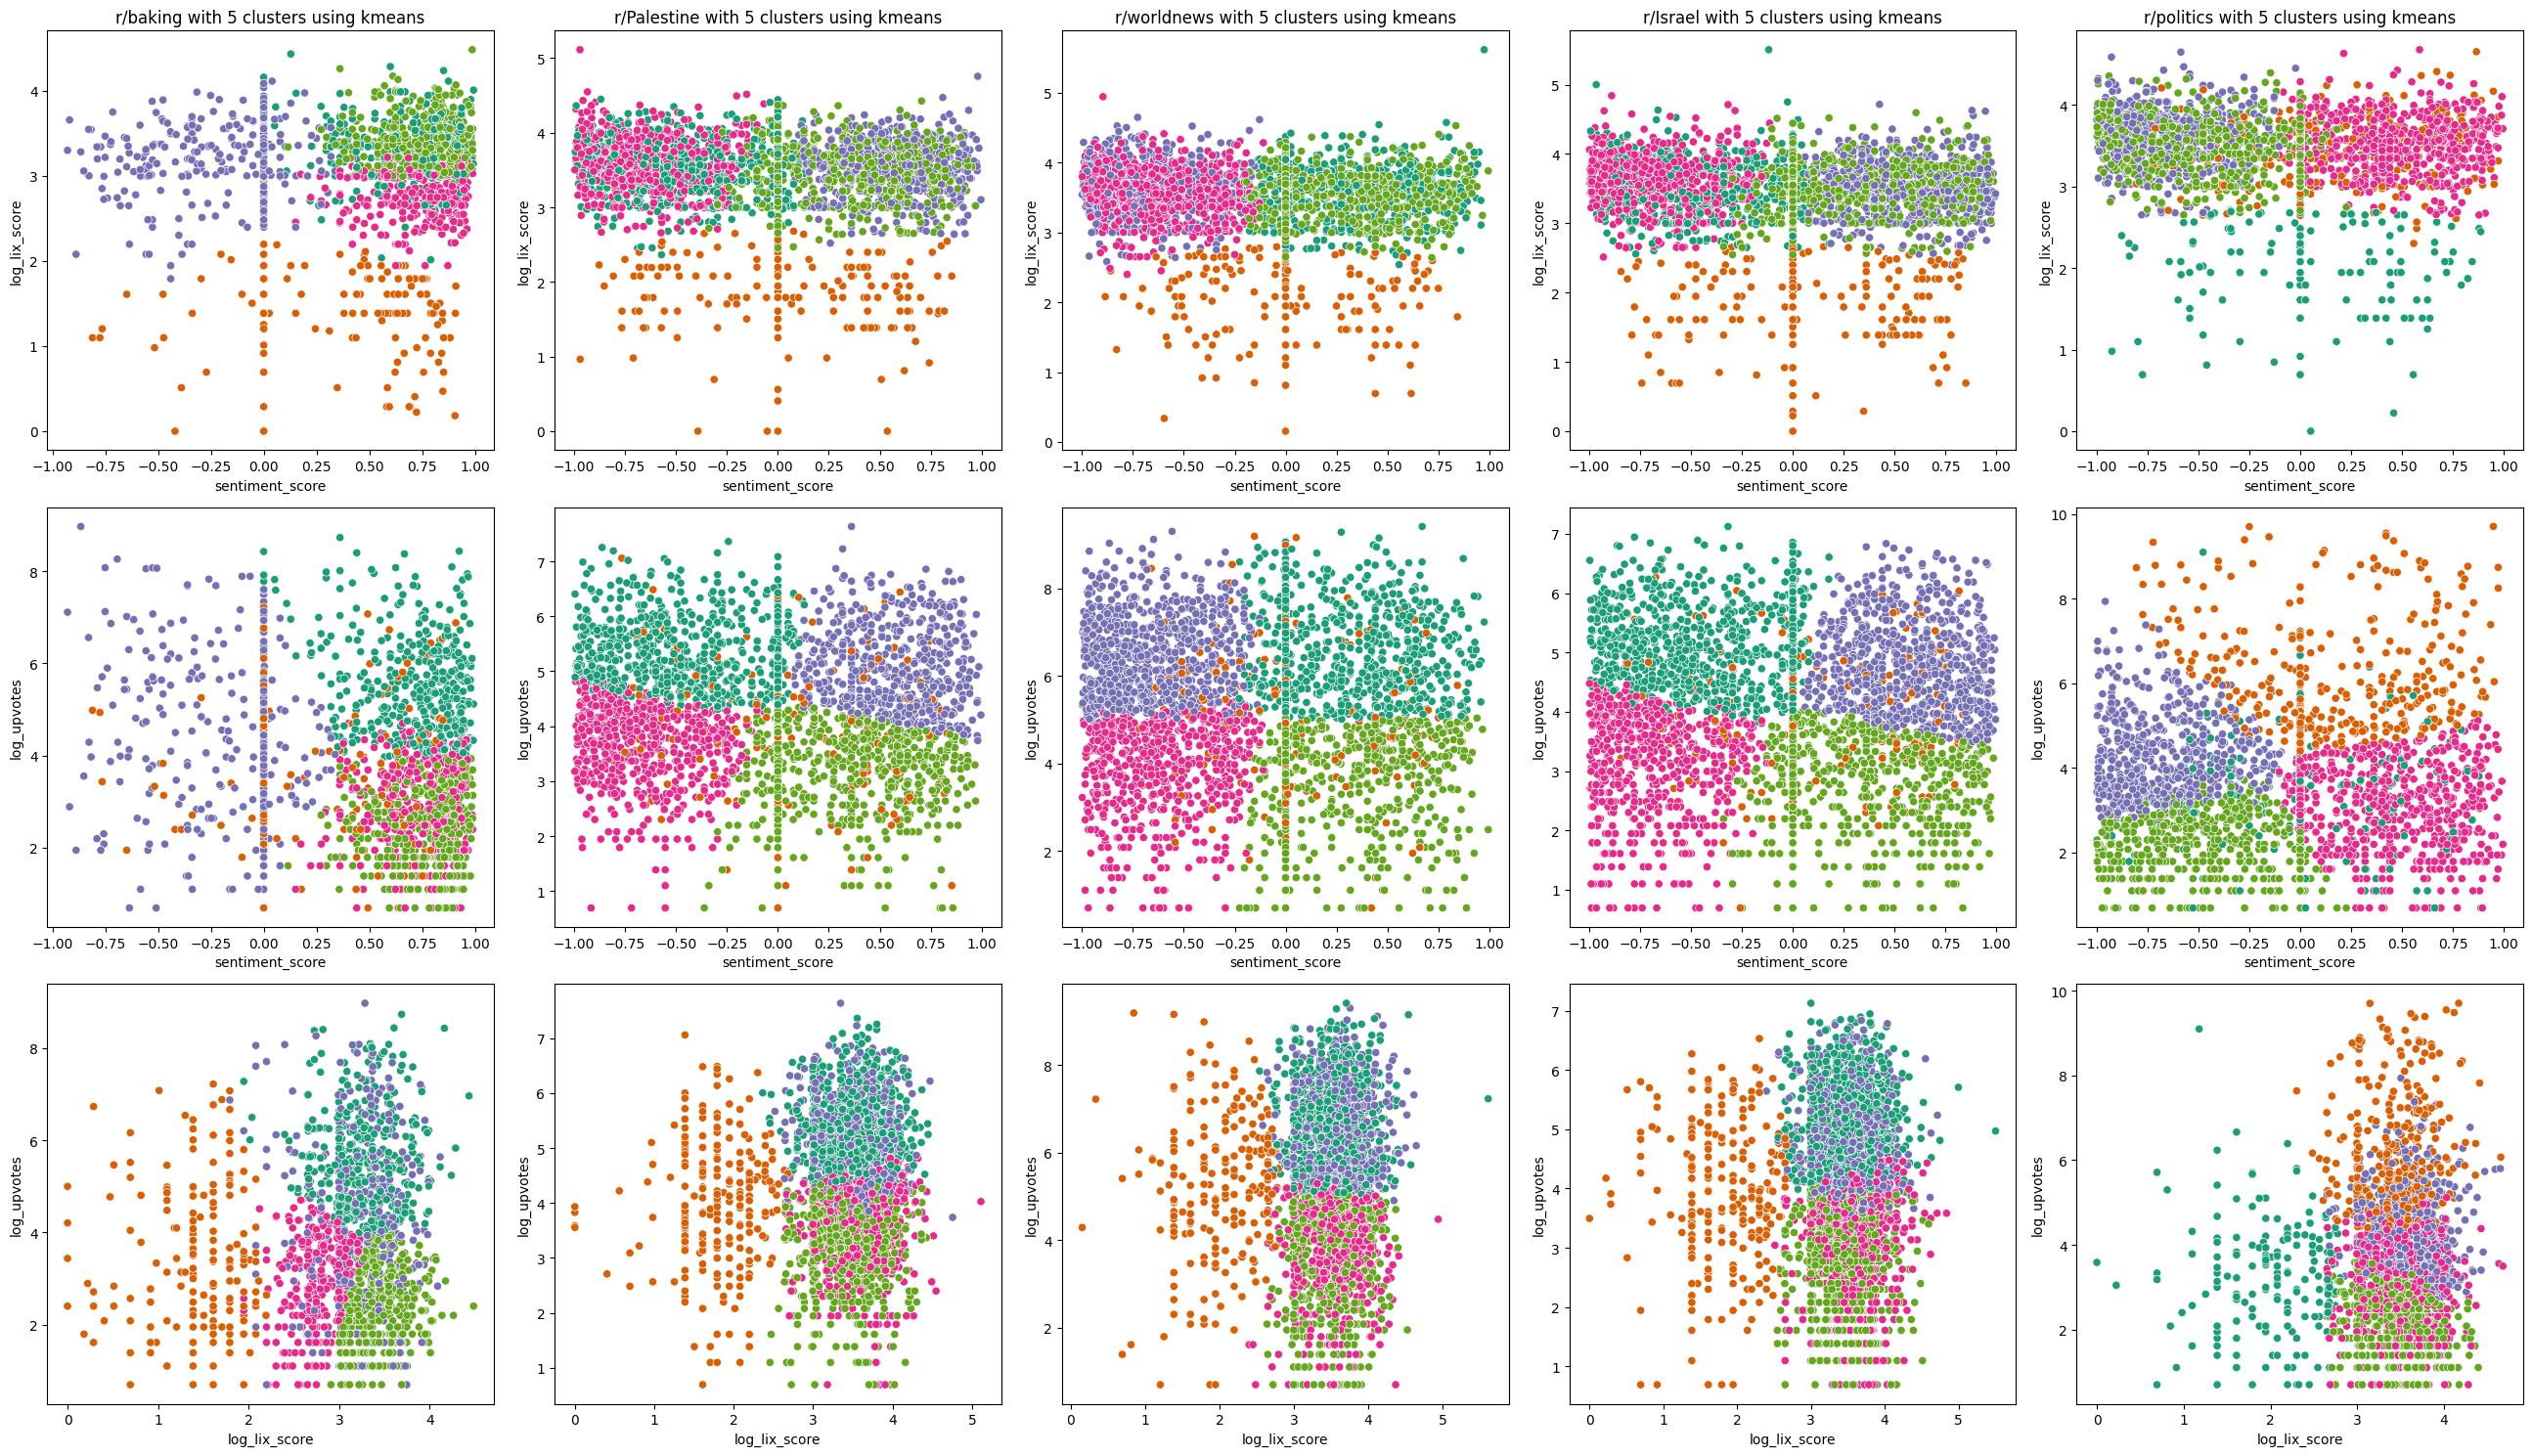

In [117]:
fig, axes = plt.subplots(nrows=3, ncols=n_subs, figsize=(26, 15))



method = 'kmeans' #DBSCAN, GMM, kmeans
cluster_type = f'{method}_cluster'

for i, (sub, df) in enumerate(dfs_clustered.items()):
    n_clusters = df[cluster_type].nunique()

    # Set color: grey for cluster -1, others will use a colormap
    colors = df[cluster_type].apply(lambda x: 'grey' if x == -1 else None)
    alphas = df[cluster_type].apply(lambda x: 0.2 if x == -1 else 1.0)
    
    # Handle valid colors for other clusters
    cmap = plt.get_cmap('Dark2', n_clusters)
    cluster_colors = df[cluster_type].apply(lambda x: cmap(x) if x != -1 else 'grey')

    # Plot the 2D scatterplots
    sns.scatterplot(ax=axes[0, i], data=df, x=attribute_cols[0], y=attribute_cols[1], hue=cluster_colors, palette='Dark2', legend=False, alpha = alphas)
    sns.scatterplot(ax=axes[1, i], data=df, x=attribute_cols[0], y=attribute_cols[2], hue=cluster_colors, palette='Dark2', legend=False, alpha = alphas)
    sns.scatterplot(ax=axes[2, i], data=df, x=attribute_cols[1], y=attribute_cols[2], hue=cluster_colors, palette='Dark2', legend=False, alpha = alphas)

    axes[0, i].set_title(f'r/{sub} with {n_clusters} clusters using {method}')

plt.tight_layout()
plt.show()

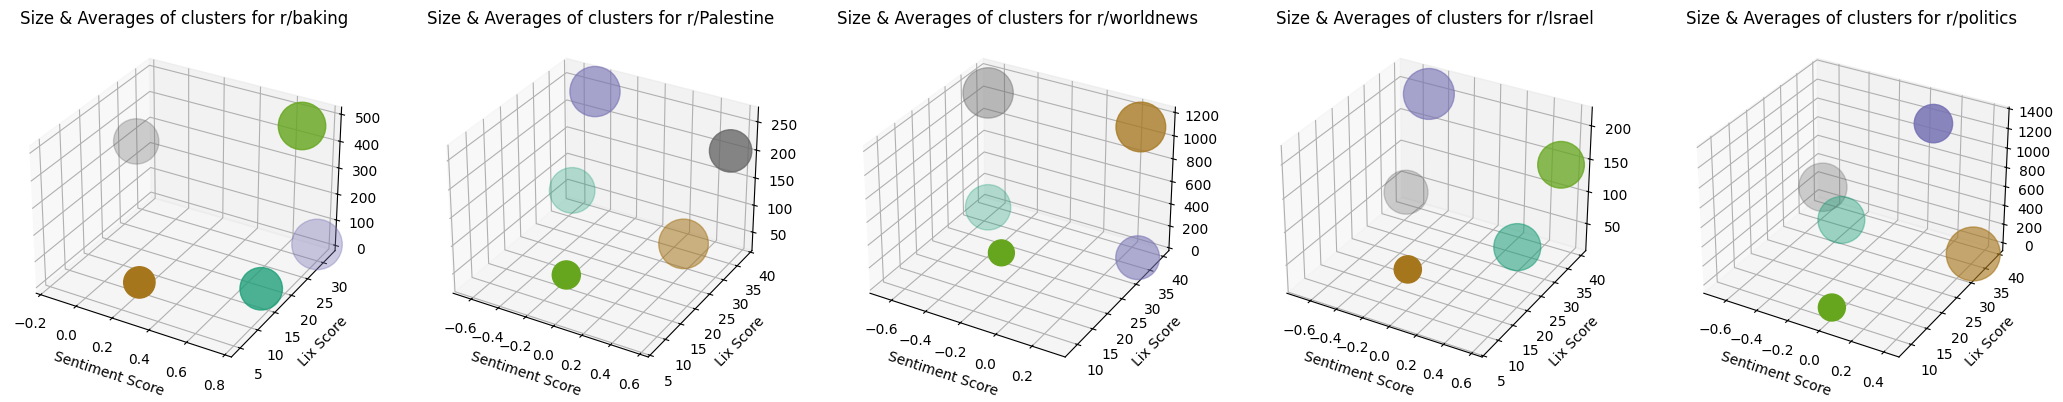

In [118]:
cluster_stats = {}

method = 'kmeans' #DBSCAN, GMM, kmeans
cluster_type = f'{method}_cluster'

for sub, df in dfs_clustered.items():
    cluster_stats[sub] = pd.DataFrame(columns=['sub', 'cluster', 'observations', 'percentage', 'avg_upvotes', 'avg_lix_score', 'avg_sentiment_score', 'upvotes_std', 'lix_score_std', 'sentiment_score_std']) #
    total_observations = len(df)
    for cluster in df[cluster_type].unique():
        cluster_df = df[df[cluster_type] == cluster]
        cluster_observations = len(cluster_df)
        percentage = cluster_observations / total_observations
        avg_upvotes = cluster_df['upvotes'].mean()
        avg_lix_score = cluster_df['lix_score'].mean()
        avg_sentiment_score = cluster_df['sentiment_score'].mean()
        opvotes_std = cluster_df['upvotes'].std()
        lix_score_std = cluster_df['lix_score'].std()
        sentiment_score_std = cluster_df['sentiment_score'].std()
        
        cluster_stats[sub].loc[cluster] = {
            'sub': sub,
            'cluster': cluster,
            'observations': cluster_observations,
            'percentage': percentage,
            'avg_upvotes': avg_upvotes,
            'avg_lix_score': avg_lix_score,
            'avg_sentiment_score': avg_sentiment_score,
            'upvotes_std': opvotes_std,
            'lix_score_std': lix_score_std,
            'sentiment_score_std': sentiment_score_std
        }

fig, axes = plt.subplots(nrows = 1, ncols = n_subs, figsize=(26, 5), subplot_kw={'projection':'3d'})

for i, (sub, df) in enumerate(cluster_stats.items()):
    n_clusters = df.shape[0]
    # #Plot the 3d scatterplot
    axes[i].scatter(df['avg_sentiment_score'], df['avg_lix_score'], df['avg_upvotes'], facecolors='none', c = df['cluster'], cmap = 'Dark2', s = df['percentage']*100*50)
    axes[i].set_title(f'Size & Averages of clusters for r/{sub}')
    axes[i].set_xlabel('Sentiment Score')
    axes[i].set_ylabel('Lix Score')